In [82]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrublet as scr
import matplotlib.image as img
import scanpy.external as sce
import harmonypy as hm
import celltypist
from celltypist import models

# Data Loading

In [2]:
sc.settings.figdir = './figures'

In [19]:
sample_paths = [
    "./samples/HB17_PDX_filtered_feature_bc_matrix/",
    "./samples/HB17_background_filtered_feature_bc_matrix/",
    "./samples/HB17_tumor_filtered_feature_bc_matrix/",
    "./samples/HB30_PDX_filtered_feature_bc_matrix/",
    "./samples/HB30_tumor_filtered_feature_bc_matrix/",
    "./samples/HB53_background_filtered_feature_bc_matrix/",
    "./samples/HB53_tumor_filtered_feature_bc_matrix/"
]

sample_names = ["hb17_pdx", "hb17_back", "hb17_tumor", "hb30_pdx", "hb30_tumor", "hb53_back", "hb53_tumor"]

adatas = {}
for path, name in zip(sample_paths, sample_names):
    adata = sc.read_10x_mtx(path, var_names='gene_symbols')
    adata.obs['sample'] = name
    adatas[name] = adata
    print(f"Loaded {name}: {adata.n_obs} cells, {adata.n_vars} genes")

Loaded hb17_pdx: 8027 cells, 33538 genes
Loaded hb17_back: 11197 cells, 33538 genes
Loaded hb17_tumor: 7995 cells, 33538 genes
Loaded hb30_pdx: 10303 cells, 33538 genes
Loaded hb30_tumor: 19042 cells, 33538 genes
Loaded hb53_back: 8540 cells, 33538 genes
Loaded hb53_tumor: 12832 cells, 33538 genes


# Preprocessing 

Let's first find the number and percent of mitochondrial genes in each sample

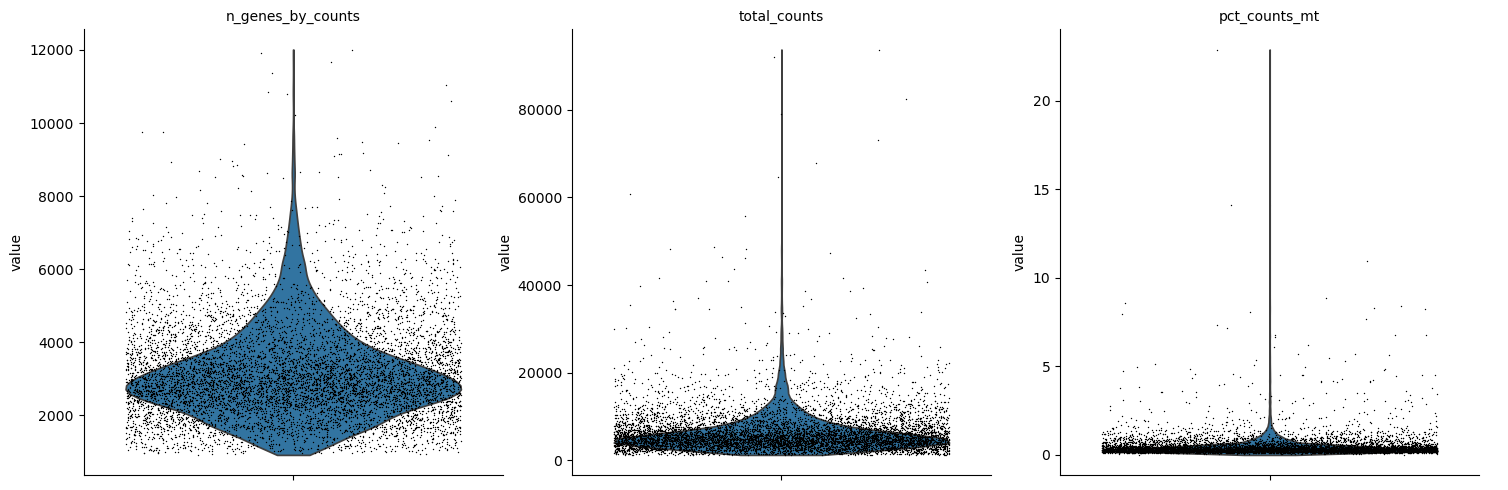

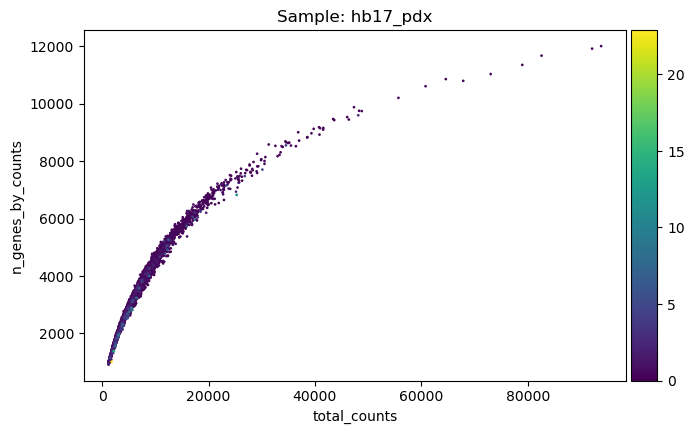

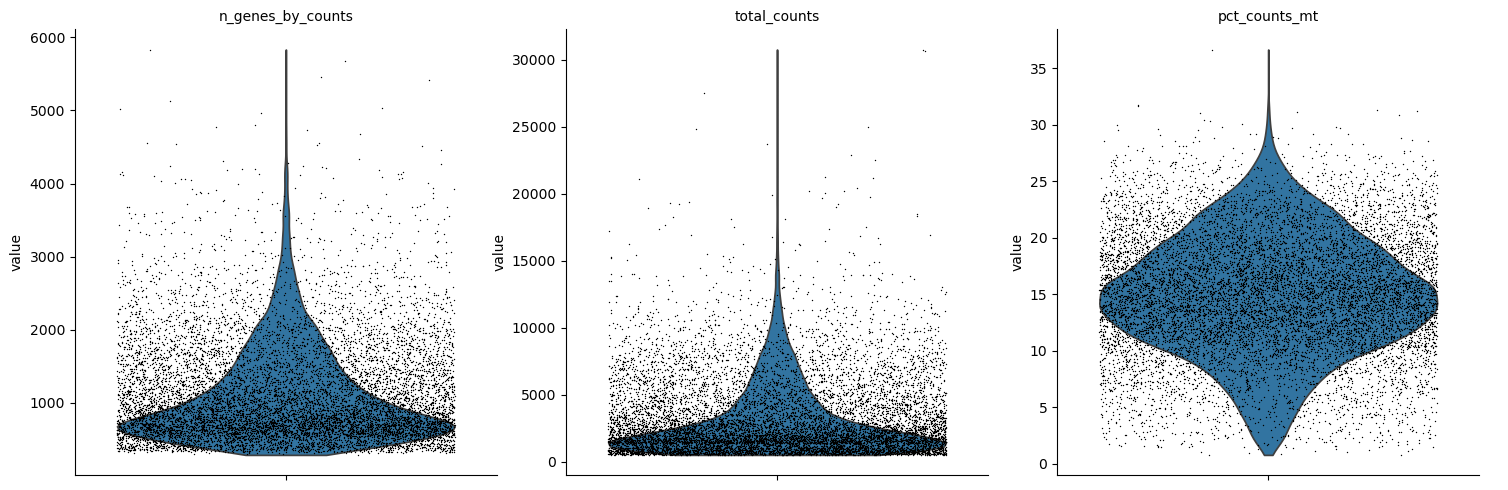

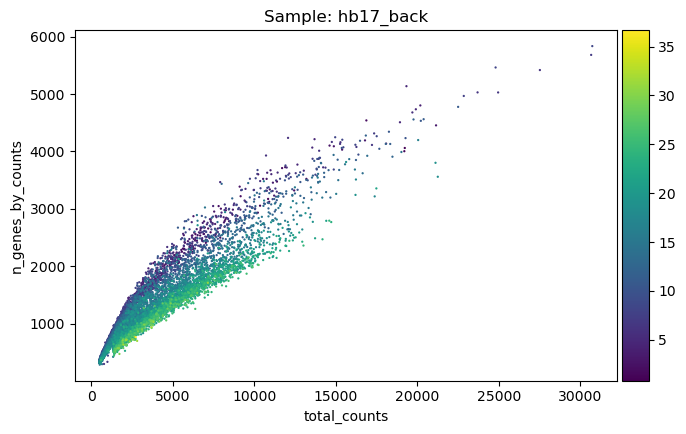

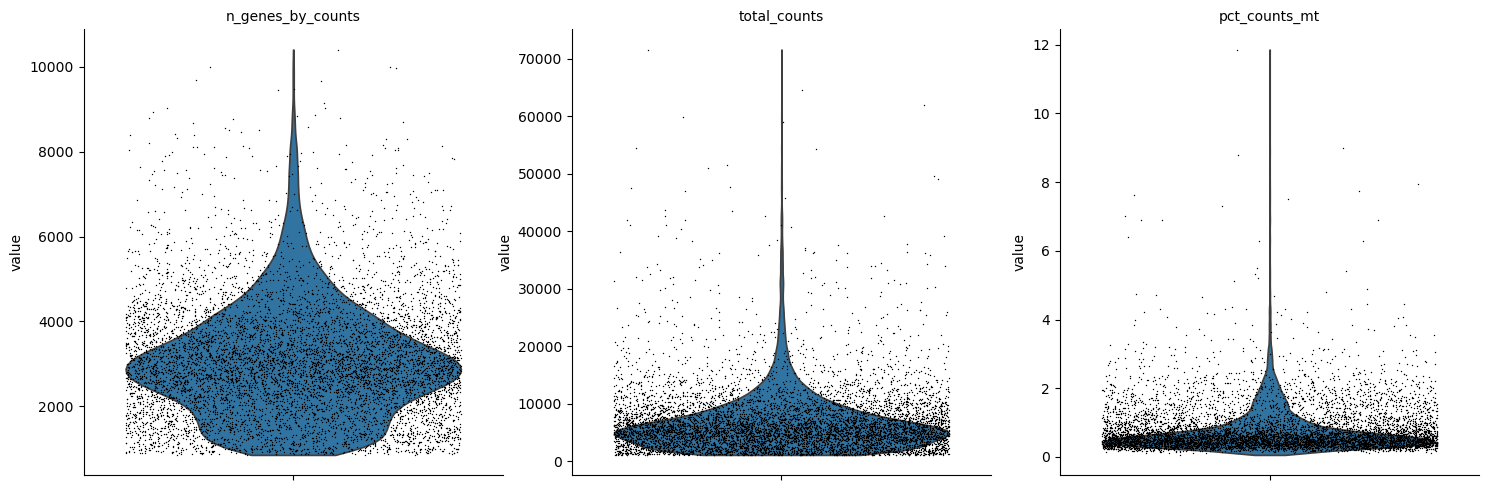

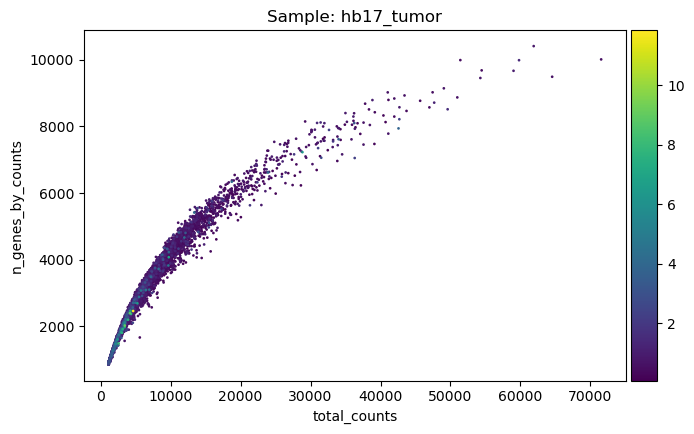

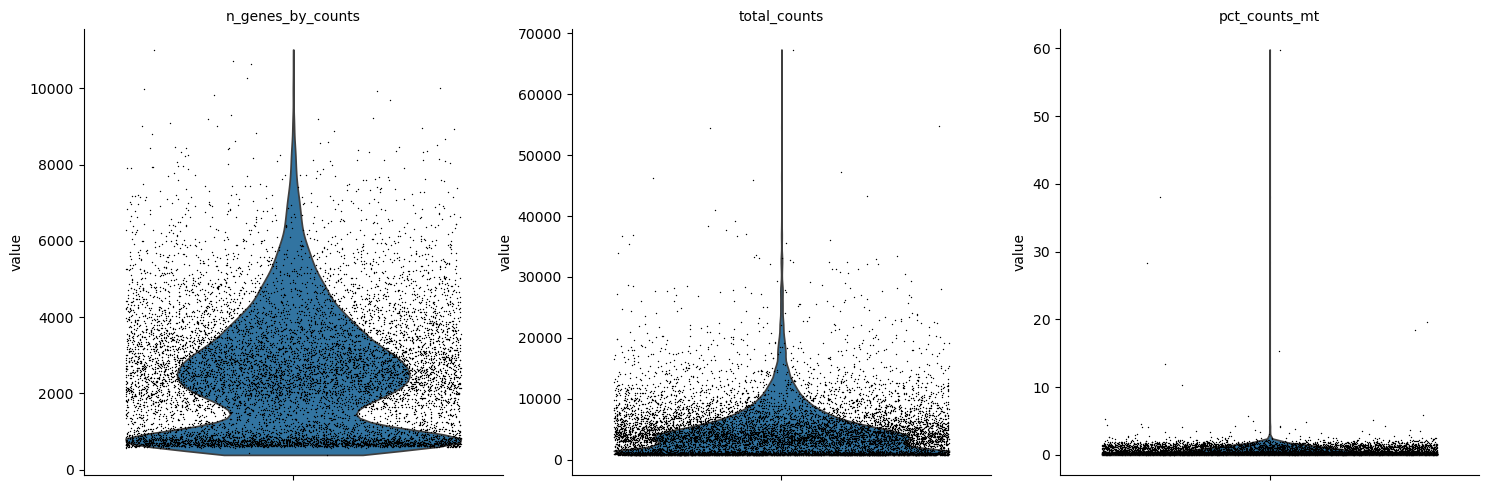

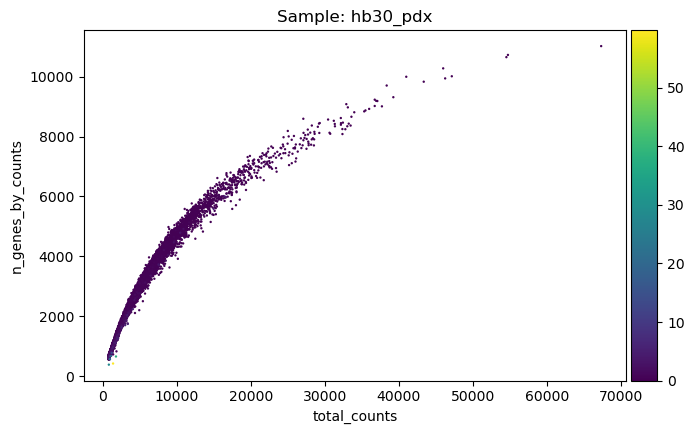

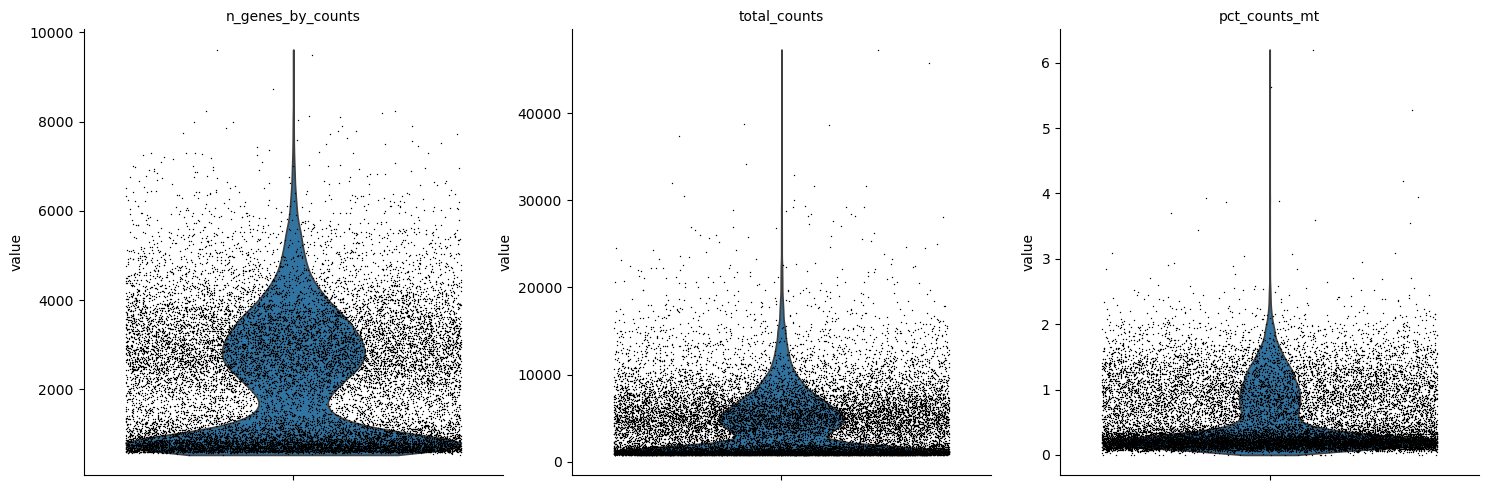

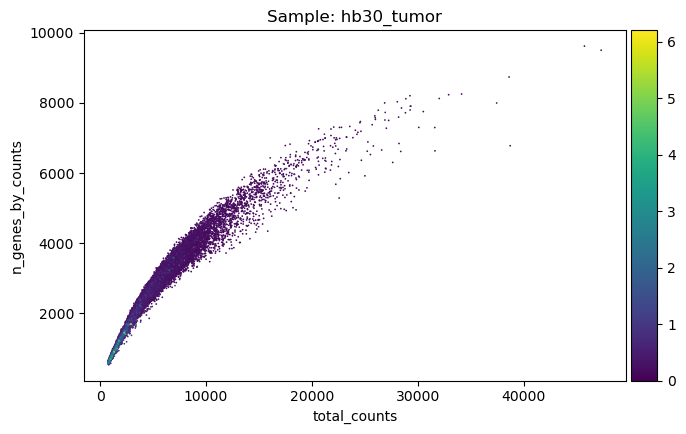

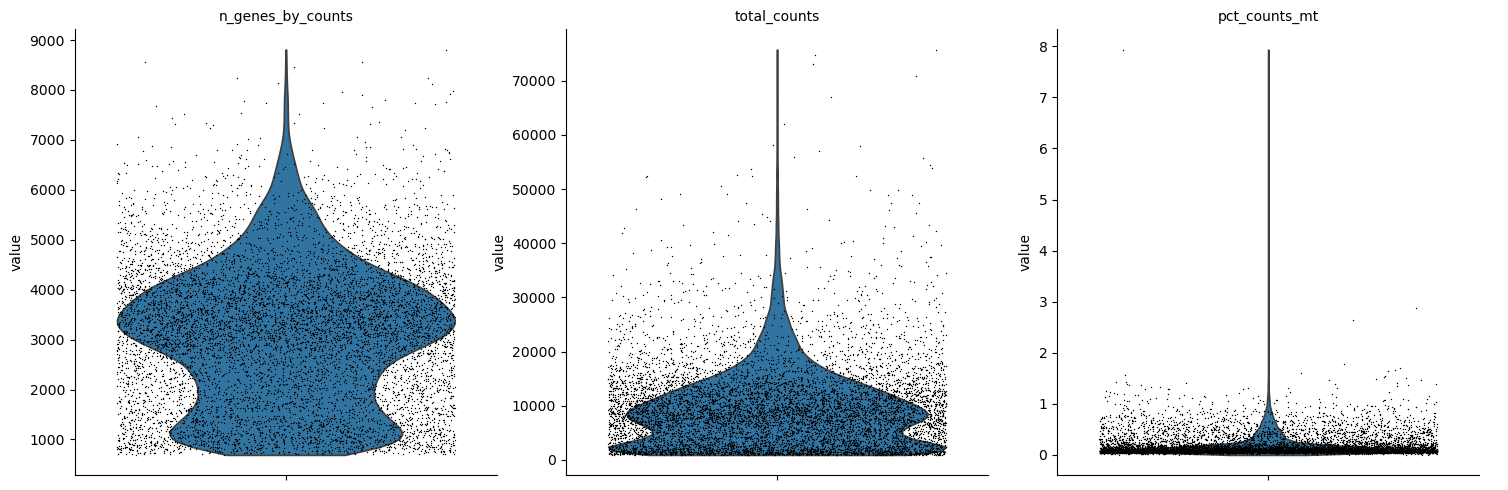

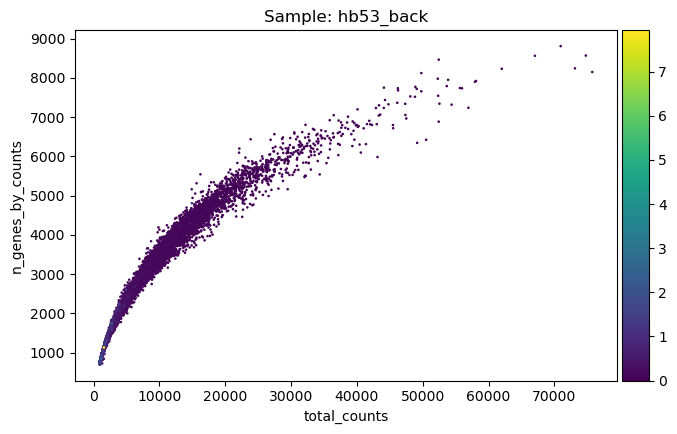

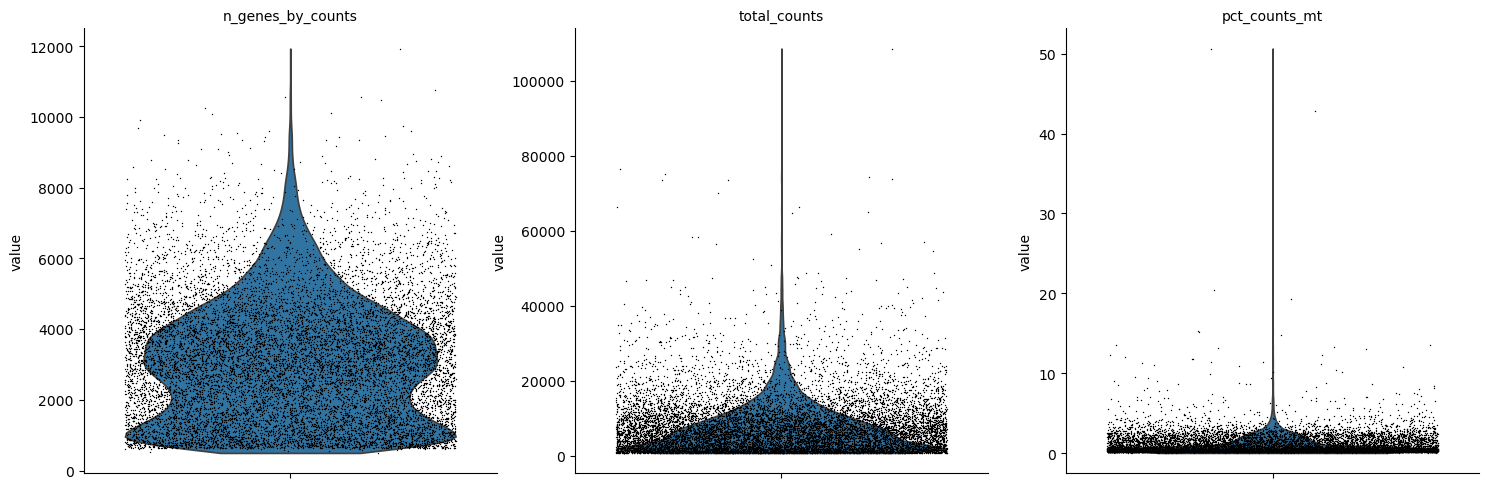

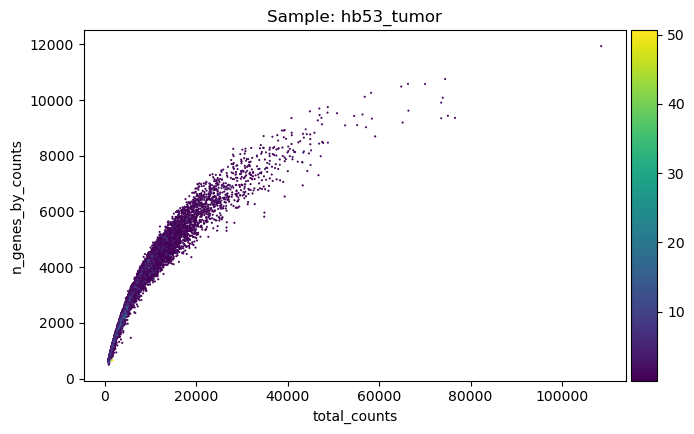

In [20]:
for sample_name, adata in adatas.items():
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)
    sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True)
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title=f"Sample: {sample_name}")

## Filtering

In [25]:
for sample_name, adata in adatas.items():
    sc.pp.filter_cells(adatas[sample_name], min_counts=800)
    sc.pp.filter_cells(adatas[sample_name], min_genes=500)
    sc.pp.filter_cells(adatas[sample_name], max_counts=70000)
    sc.pp.filter_cells(adatas[sample_name], max_genes=10000)
    adatas[sample_name] = adata[adata.obs['pct_counts_mt'] < 10].copy()
    print(f"Sample {sample_name}: {adatas[sample_name].n_obs} cells remaining after all filtering")
    print(f"Sampel {sample_name}: {adatas[sample_name].n_vars} genes remaining after all filtering")

Sample hb17_pdx: 8015 cells remaining after all filtering
Sampel hb17_pdx: 25232 genes remaining after all filtering
Sample hb17_back: 1688 cells remaining after all filtering
Sampel hb17_back: 17274 genes remaining after all filtering
Sample hb17_tumor: 7992 cells remaining after all filtering
Sampel hb17_tumor: 25334 genes remaining after all filtering
Sample hb30_pdx: 10100 cells remaining after all filtering
Sampel hb30_pdx: 25858 genes remaining after all filtering
Sample hb30_tumor: 18732 cells remaining after all filtering
Sampel hb30_tumor: 26899 genes remaining after all filtering
Sample hb53_back: 8536 cells remaining after all filtering
Sampel hb53_back: 25204 genes remaining after all filtering
Sample hb53_tumor: 12786 cells remaining after all filtering
Sampel hb53_tumor: 26843 genes remaining after all filtering


In [26]:
for sample_name, adata in adatas.items():
    sc.pp.filter_genes(adata, min_cells=3)
    print(f"Sample {sample_name}: {adatas[sample_name].n_obs} cells remaining after all filtering")
    print(f"Sample {sample_name}: {adatas[sample_name].n_vars} genes remaining after all filtering")

Sample hb17_pdx: 8015 cells remaining after all filtering
Sample hb17_pdx: 25208 genes remaining after all filtering
Sample hb17_back: 1688 cells remaining after all filtering
Sample hb17_back: 17274 genes remaining after all filtering
Sample hb17_tumor: 7992 cells remaining after all filtering
Sample hb17_tumor: 25333 genes remaining after all filtering
Sample hb30_pdx: 10100 cells remaining after all filtering
Sample hb30_pdx: 25854 genes remaining after all filtering
Sample hb30_tumor: 18732 cells remaining after all filtering
Sample hb30_tumor: 26899 genes remaining after all filtering
Sample hb53_back: 8536 cells remaining after all filtering
Sample hb53_back: 25195 genes remaining after all filtering
Sample hb53_tumor: 12786 cells remaining after all filtering
Sample hb53_tumor: 26831 genes remaining after all filtering


Now, let's perform doublet detection

In [27]:
for sample_name, adata in adatas.items():
    print(f"\nProcessing sample: {sample_name}")
    if "counts" in adata.layers:
        counts_matrix = adata.layers["counts"]
    else:
        counts_matrix = adata.X.copy()
        
    scrub = scr.Scrublet(counts_matrix)
    
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets
    
    plt.figure(figsize=(8, 6))
    scrub.plot_histogram()
    plt.savefig(f"./figures/doublet_histogram_{sample_name}.png")
    plt.close()
    n_doublets = sum(predicted_doublets)
    print(f"  Predicted doublets: {n_doublets} ({n_doublets/len(predicted_doublets)*100:.2f}%)")


Processing sample: hb17_pdx
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 12.8 seconds
  Predicted doublets: 0 (0.00%)

Processing sample: hb17_back
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 23.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 1.3 seconds
  Predicted doublets: 26 (1.54%)

Processing sample: hb17_tumor
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.0%
Estimated de

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

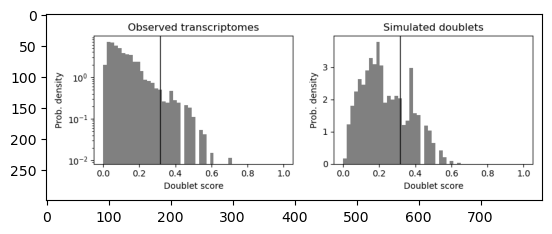

In [28]:
hb53_doublet = img.imread('./figures/doublet_histogram_hb53_tumor.png')
plt.imshow(hb53_doublet)

Based on scrublet, we can see that there is a great amount of doublets particularly in the hb53_tumor sample where it predicted around 618 doublets. Therefore let's perform further doublet filtering across the samples

In [29]:
sample_thresholds = {'hb17_pdx': 0.77,'hb17_back': 0.33,'hb17_tumor': 0.69,'hb30_pdx': 0.79,'hb30_tumor': 0.77,'hb53_back': 0.76,'hb53_tumor': 0.31}
filtered_adatas = {}

for sample_name, adata in adatas.items():
    print(f"\nProcessing sample: {sample_name}")
    
    threshold = sample_thresholds[sample_name]
    
    adata.obs['is_doublet'] = adata.obs['doublet_score'] > threshold
    
    filtered_adata = adata[~adata.obs['is_doublet']].copy()
    filtered_adatas[sample_name] = filtered_adata
    
    n_cells_before = adata.shape[0]
    n_cells_after = filtered_adata.shape[0]
    n_removed = n_cells_before - n_cells_after
    print(f"Sample: {sample_name}")
    print(f"Threshold: {threshold}")
    print(f"Cells before filtering: {n_cells_before}")
    print(f"Cells after filtering: {n_cells_after}")
    print(f"Cells removed: {n_removed} ({n_removed/n_cells_before*100:.2f}%)")


Processing sample: hb17_pdx
Sample: hb17_pdx
Threshold: 0.77
Cells before filtering: 8015
Cells after filtering: 8015
Cells removed: 0 (0.00%)

Processing sample: hb17_back
Sample: hb17_back
Threshold: 0.33
Cells before filtering: 1688
Cells after filtering: 1662
Cells removed: 26 (1.54%)

Processing sample: hb17_tumor
Sample: hb17_tumor
Threshold: 0.69
Cells before filtering: 7992
Cells after filtering: 7991
Cells removed: 1 (0.01%)

Processing sample: hb30_pdx
Sample: hb30_pdx
Threshold: 0.79
Cells before filtering: 10100
Cells after filtering: 10100
Cells removed: 0 (0.00%)

Processing sample: hb30_tumor
Sample: hb30_tumor
Threshold: 0.77
Cells before filtering: 18732
Cells after filtering: 18727
Cells removed: 5 (0.03%)

Processing sample: hb53_back
Sample: hb53_back
Threshold: 0.76
Cells before filtering: 8536
Cells after filtering: 8534
Cells removed: 2 (0.02%)

Processing sample: hb53_tumor
Sample: hb53_tumor
Threshold: 0.31
Cells before filtering: 12786
Cells after filtering: 

In [32]:
for sample_name, adata in filtered_adatas.items():
    print(f"Sample {sample_name}: {filtered_adatas[sample_name].n_obs} cells remaining after all filtering")
    print(f"Sampel {sample_name}: {filtered_adatas[sample_name].n_vars} genes remaining after all filtering")

Sample hb17_pdx: 8015 cells remaining after all filtering
Sampel hb17_pdx: 25208 genes remaining after all filtering
Sample hb17_back: 1662 cells remaining after all filtering
Sampel hb17_back: 17274 genes remaining after all filtering
Sample hb17_tumor: 7991 cells remaining after all filtering
Sampel hb17_tumor: 25333 genes remaining after all filtering
Sample hb30_pdx: 10100 cells remaining after all filtering
Sampel hb30_pdx: 25854 genes remaining after all filtering
Sample hb30_tumor: 18727 cells remaining after all filtering
Sampel hb30_tumor: 26899 genes remaining after all filtering
Sample hb53_back: 8534 cells remaining after all filtering
Sampel hb53_back: 25195 genes remaining after all filtering
Sample hb53_tumor: 12099 cells remaining after all filtering
Sampel hb53_tumor: 26831 genes remaining after all filtering


In [33]:
filter_stats = {
    'Sample': [],
    'Cells Before': [],
    'Genes Before': [],
    'Cells After': [],
    'Genes After': [],
    'Cells Removed': [],
    'Cells Removed (%)': [],
    'Genes Removed': [],
    'Genes Removed (%)': []
}

before_stats = {
    'hb17_pdx': {'cells': 8027, 'genes': 33538},
    'hb17_back': {'cells': 11197, 'genes': 33538},
    'hb17_tumor': {'cells': 7995, 'genes': 33538},
    'hb30_pdx': {'cells': 10303, 'genes': 33538},
    'hb30_tumor': {'cells': 19042, 'genes': 33538},
    'hb53_back': {'cells': 8540, 'genes': 33538},
    'hb53_tumor': {'cells': 12832, 'genes': 33538}
}

after_stats = {
    'hb17_pdx': {'cells': 8015, 'genes': 25208},
    'hb17_back': {'cells': 1662, 'genes': 17274},
    'hb17_tumor': {'cells': 7991, 'genes': 25333},
    'hb30_pdx': {'cells': 10100, 'genes': 25854},
    'hb30_tumor': {'cells': 18727, 'genes': 26899},
    'hb53_back': {'cells': 8534, 'genes': 25195},
    'hb53_tumor': {'cells': 12099, 'genes': 26831}
}

for sample in before_stats.keys():
    cells_before = before_stats[sample]['cells']
    genes_before = before_stats[sample]['genes']
    cells_after = after_stats[sample]['cells']
    genes_after = after_stats[sample]['genes']
    cells_removed = cells_before - cells_after
    cells_removed_pct = (cells_removed / cells_before) * 100
    genes_removed = genes_before - genes_after
    genes_removed_pct = (genes_removed / genes_before) * 100
    filter_stats['Sample'].append(sample)
    filter_stats['Cells Before'].append(cells_before)
    filter_stats['Genes Before'].append(genes_before)
    filter_stats['Cells After'].append(cells_after)
    filter_stats['Genes After'].append(genes_after)
    filter_stats['Cells Removed'].append(cells_removed)
    filter_stats['Cells Removed (%)'].append(cells_removed_pct)
    filter_stats['Genes Removed'].append(genes_removed)
    filter_stats['Genes Removed (%)'].append(genes_removed_pct)

df = pd.DataFrame(filter_stats)
df['Cells Removed (%)'] = df['Cells Removed (%)'].apply(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x)
df['Genes Removed (%)'] = df['Genes Removed (%)'].apply(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x)
df

Sample  Cells Before  Genes Before  Cells After  Genes After  \
0    hb17_pdx          8027         33538         8015        25208   
1   hb17_back         11197         33538         1662        17274   
2  hb17_tumor          7995         33538         7991        25333   
3    hb30_pdx         10303         33538        10100        25854   
4  hb30_tumor         19042         33538        18727        26899   
5   hb53_back          8540         33538         8534        25195   
6  hb53_tumor         12832         33538        12099        26831   

   Cells Removed Cells Removed (%)  Genes Removed Genes Removed (%)  
0             12              0.1%           8330             24.8%  
1           9535             85.2%          16264             48.5%  
2              4              0.1%           8205             24.5%  
3            203              2.0%           7684             22.9%  
4            315              1.7%           6639             19.8%  
5              6              0.1%           8343             24.9%  
6            733              5.7%           6707             20.0%

Preprocessing discussion

# Normalization

First let's combine the samples

In [134]:
adata_list = list(filtered_adatas.values())
sample_names = list(filtered_adatas.keys())

combined = ad.concat(adata_list, join='outer', label='sample', keys=sample_names)

In [135]:
combined

AnnData object with n_obs × n_vars = 67128 × 28347
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'is_doublet'

In [136]:
combined.layers['counts'] = combined.X.copy()
sc.pp.normalize_total(combined, target_sum=10000)
sc.pp.log1p(combined)

# Feature Selection

Let's extract the highly variable genes

In [137]:
sc.pp.highly_variable_genes(combined,flavor="seurat",n_top_genes=3000,batch_key="sample")
variable_genes_n = combined.var["highly_variable"].sum()
not_variable_n = 28347 - combined.var["highly_variable"].sum()
print(f'Number of highly variable genes: {variable_genes_n}')
print(f'Number of not highly variable genes: {not_variable_n}')

Number of highly variable genes: 3000
Number of not highly variable genes: 25347


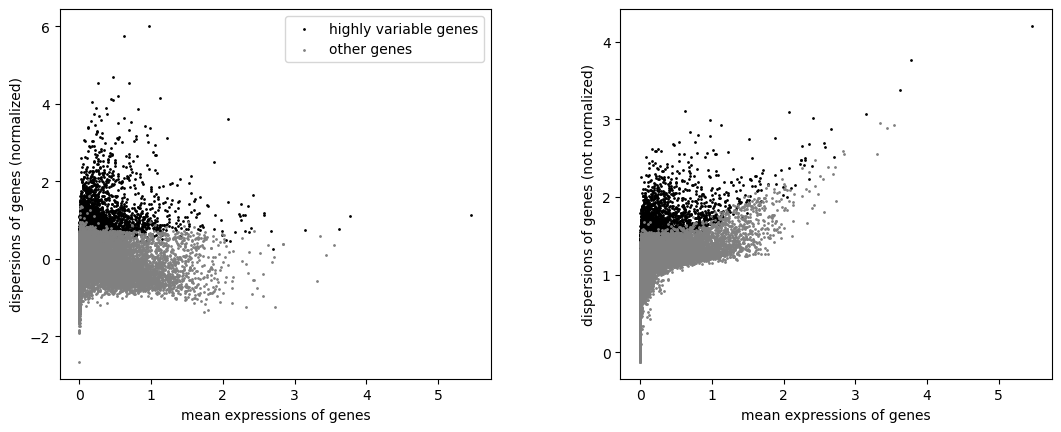

In [139]:
sc.pl.highly_variable_genes(combined, show=True)

In [140]:
filtered_combined = combined[:, combined.var.highly_variable]

# PCA

Now let's compute PCA on the log-normalized matrix

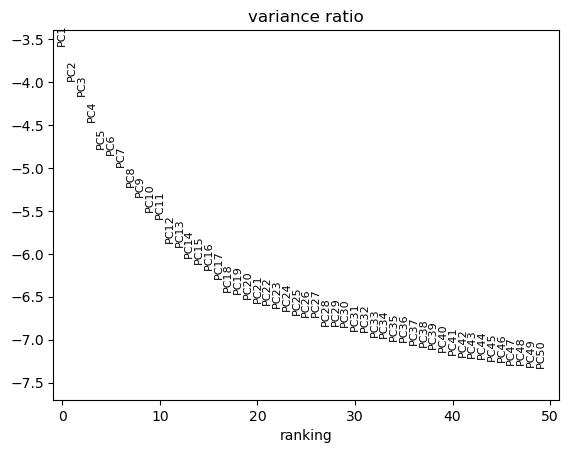

In [143]:
sc.pp.scale(filtered_combined)
sc.pp.pca(filtered_combined)
sc.pl.pca_variance_ratio(filtered_combined, n_pcs=50, log=True)

Based on the variance ratio plot, I think using between 20-30 principal components for the analysis. This plot shows the log variance ratio for each PC, and you're looking for the "elbow point" - where the curve starts to flatten out, indicating diminishing returns for including additional PCs. In your plot, there's a noticeable change in the slope around PC20-30. The first few PCs (1-10) show a steeper decline in variance ratio, suggesting they capture significant structure in your data. After approximately PC20, the curve becomes more gradual, indicating that additional PCs are capturing less meaningful variation and potentially more noise.

# Clustering and Visualization

In [144]:
sc.pp.neighbors(filtered_combined, n_pcs=30)
sc.tl.umap(filtered_combined, random_state=42)

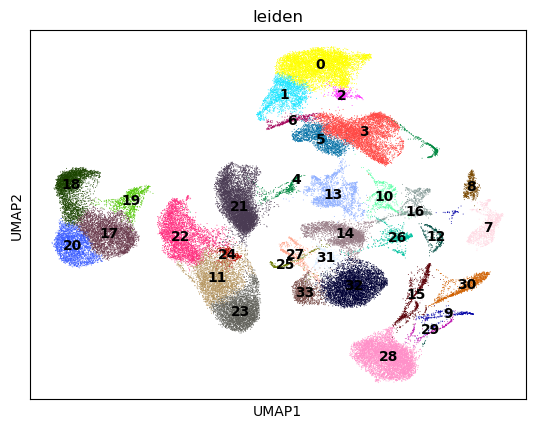

In [145]:
sc.tl.leiden(filtered_combined, flavor='igraph', n_iterations=2, random_state=42)
sc.pl.umap(filtered_combined, color=['leiden'], legend_loc='on data')

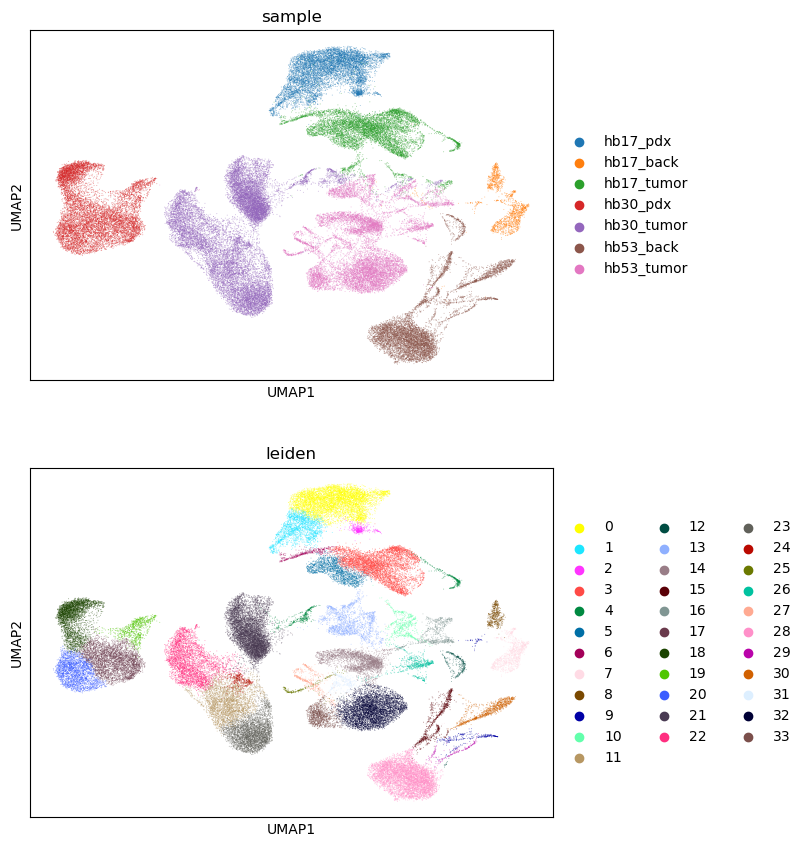

In [146]:
sc.pl.umap(filtered_combined, color=['sample', 'leiden'], alpha=0.5, ncols=1)

There is clearly a batch effect here since the cells are all separated based on the sample, therefore integration needs to be performed

# Integration

Here, let's use harmony to perform integration

In [200]:
filtered_combined_int = filtered_combined.copy()
ho = hm.run_harmony(filtered_combined_int.obsm['X_pca'], filtered_combined_int.obs, 'sample')
filtered_combined_int.obsm['X_pca_harmony'] = ho.Z_corr.T

2025-04-30 12:08:21,444 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-04-30 12:08:36,137 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-04-30 12:08:36,390 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-04-30 12:08:59,671 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-04-30 12:09:23,013 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-04-30 12:09:46,542 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [202]:
sc.pp.neighbors(filtered_combined_int, use_rep='X_pca_harmony')
sc.tl.umap(filtered_combined_int, random_state=42)
sc.tl.leiden(filtered_combined_int, flavor='igraph', n_iterations=2, random_state=42)

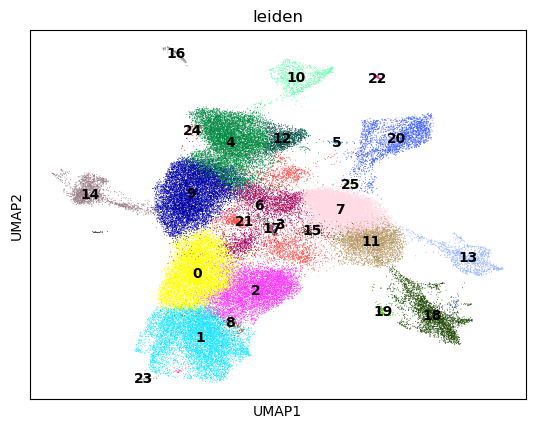

In [149]:
sc.pl.umap(filtered_combined_int, color=['leiden'], legend_loc='on data')

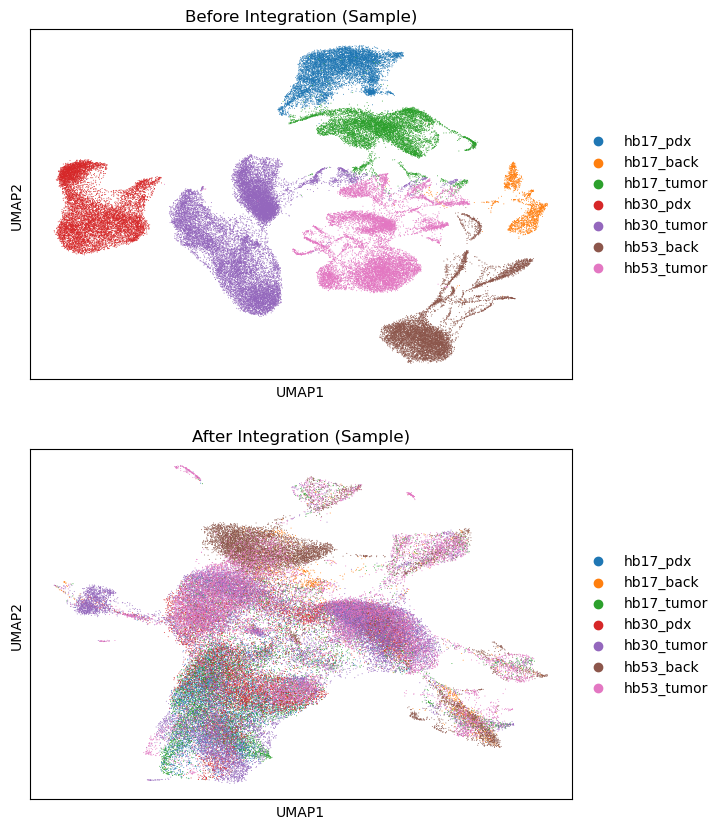

In [150]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sc.pl.umap(filtered_combined, color="sample", title="Before Integration (Sample)", show=False, ax=ax[0])
sc.pl.umap(filtered_combined_int, color="sample", title="After Integration (Sample)", show=False, ax=ax[1])
plt.show()

# Marker Gene Analysis

In [219]:
sc.tl.rank_genes_groups(filtered_combined_int, groupby="leiden", method="wilcoxon")

/projectnb/bf528/students/nhwong/.conda/envs/scanpy_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/projectnb/bf528/students/nhwong/.conda/envs/scanpy_base/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/projectnb/bf528/students/nhwong/.conda/envs/scanpy_base/lib/python

In [153]:
result = filtered_combined_int.uns['rank_genes_groups']
groups = result['names'].dtype.names

In [154]:
top_markers = pd.DataFrame()
for group in groups:
    genes = result['names'][group][:5]
    scores = result['scores'][group][:5]
    pvals = result['pvals'][group][:5]
    logfcs = result['logfoldchanges'][group][:5]
    
    cluster_markers = pd.DataFrame({
        'cluster': [group]*5,
        'gene': genes,
        'score': scores,
        'log2_fold_change': logfcs,
        'p_value': pvals
    })
    
    top_markers = pd.concat([top_markers, cluster_markers])

top_markers = top_markers.reset_index(drop=True)

In [155]:
top_markers

cluster        gene      score  log2_fold_change       p_value
0         0        NKD1  85.122108               NaN  0.000000e+00
1         0       DCDC2  82.840836               NaN  0.000000e+00
2         0      HS3ST5  72.711441               NaN  0.000000e+00
3         0       FRAS1  70.158859               NaN  0.000000e+00
4         0  SNAP25-AS1  66.026115               NaN  0.000000e+00
..      ...         ...        ...               ...           ...
125      25         HBB   7.054019               NaN  1.738220e-12
126      25      MT-CO1   6.140762               NaN  8.212640e-10
127      25         FTL   6.090173               NaN  1.127886e-09
128      25         FGA   5.281868               NaN  1.278732e-07
129      25         FGB   5.262066               NaN  1.424459e-07

[130 rows x 5 columns]

In [156]:
marker_table = pd.pivot_table(
    top_markers, 
    values='gene', 
    index=None, 
    columns='cluster', 
    aggfunc=lambda x: ', '.join(x)
)
marker_table = marker_table.T
marker_table

gene
cluster                                             
0             NKD1, DCDC2, HS3ST5, FRAS1, SNAP25-AS1
1                   HUNK, PDE4D, TSPAN5, NRXN3, NKD1
10                 FYN, PTPRC, CELF2, PRKCH, ANKRD44
11              FTL, STEAP1B, PEG10, AC105402.3, ALB
12               CYP3A4, NRG1, GPAT3, CYP3A5, CYP2B6
13               PRKG1, COL4A2, IGFBP7, PDE3A, ZFPM2
14           SGCZ, FST, PBX1, AC007319.1, AC098617.1
15                  ALB, AC105402.3, FTL, FGB, PEG10
16              HBB, SLC4A1, SLC25A37, SPTA1, SPECC1
17                  BICC1, GLIS3, DTNA, STK39, CREB5
18               TCF4, LDB2, ST6GALNAC3, PTPRB, FLT1
19          ST6GALNAC3, AKAP12, FLT1, RAPGEF5, KALRN
2        DIAPH3, AC016205.1, BRIP1, RFC3, AC091057.6
20                ZEB2, SLC8A1, CELF2, DOCK2, PLXDC2
21                  CPA3, SLC24A3, KIT, HPGD, IL18R1
22                  RIMS2, PTPRN2, ST18, CADPS, DGKB
23         AC021006.2, PCDH7, ST6GAL2, CASC15, PDE4B
24          LINC00598, IL1RAPL2, ACSL1, STOM, ADRA1A
25                        HBB, MT-CO1, FTL, FGA, FGB
3                JUND, GPX3, MTRNR2L12, H3F3B, NORAD
4                     CFH, CYP3A5, ABCB11, PCSK6, C3
5                      NRG1, NAMPT, CRP, ABCB11, SDS
6                 AC105402.3, MT-CO3, AFP, FTL, GPC3
7               AC105402.3, ALB, FTL, MT-CO3, MT-CO1
8               AC098617.1, SHISA6, FGF13, NTM, CPS1
9              GPC3, LIPC, AL391117.1, NR1H4, PTP4A1

# Cell Label Annotation - Automatic

In [203]:
combined_celltypist = filtered_combined_int.copy()
combined_celltypist.obs_names_make_unique()
combined_celltypist.var_names_make_unique()

In [158]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


model                                        description
0                        Immune_All_Low.pkl  immune sub-populations combined from 20 tissue...
1                       Immune_All_High.pkl  immune populations combined from 20 tissues of...
2                    Adult_COVID19_PBMC.pkl  peripheral blood mononuclear cell types from C...
3   Adult_CynomolgusMacaque_Hippocampus.pkl  cell types from the hippocampus of adult cynom...
4                       Adult_Human_MTG.pkl  cell types and subtypes (10x-based) from the a...
5           Adult_Human_PancreaticIslet.pkl  cell types from pancreatic islets of healthy a...
6          Adult_Human_PrefrontalCortex.pkl  cell types and subtypes from the adult human d...
7                      Adult_Human_Skin.pkl           cell types from human healthy adult skin
8                  Adult_Human_Vascular.pkl  vascular populations combined from multiple ad...
9                       Adult_Mouse_Gut.pkl  cell types in the adult mouse gut combined fro...
10            Adult_Mouse_OlfactoryBulb.pkl   cell types from the olfactory bulb of adult mice
11                Adult_Pig_Hippocampus.pkl          cell types from the adult pig hippocampus
12      Adult_RhesusMacaque_Hippocampus.pkl  cell types from the hippocampus of adult rhesu...
13                 Autopsy_COVID19_Lung.pkl  cell types from the lungs of 16 SARS-CoV-2 inf...
14         COVID19_HumanChallenge_Blood.pkl  detailed blood cell states from 16 individuals...
15             COVID19_Immune_Landscape.pkl  immune subtypes from lung and blood of COVID-1...
16                   Cells_Adult_Breast.pkl             cell types from the adult human breast
17                     Cells_Fetal_Lung.pkl    cell types from human embryonic and fetal lungs
18                   Cells_Human_Tonsil.pkl      tonsillar cell types from humans (3-65 years)
19               Cells_Intestinal_Tract.pkl  intestinal cells from fetal, pediatric (health...
20                    Cells_Lung_Airway.pkl  cell populations from scRNA-seq of five locati...
21               Developing_Human_Brain.pkl  cell types from the first-trimester developing...
22              Developing_Human_Gonads.pkl  cell types of human gonadal and adjacent extra...
23         Developing_Human_Hippocampus.pkl   cell types from the developing human hippocampus
24              Developing_Human_Organs.pkl  cell types of five endoderm-derived organs in ...
25              Developing_Human_Thymus.pkl  cell populations in embryonic, fetal, pediatri...
26               Developing_Mouse_Brain.pkl  cell types from the embryonic mouse brain betw...
27         Developing_Mouse_Hippocampus.pkl  cell types from the mouse hippocampus at postn...
28            Fetal_Human_AdrenalGlands.pkl  cell types of human fetal adrenal glands from ...
29                 Fetal_Human_Pancreas.pkl  pancreatic cell types from human embryos at 9-...
30                Fetal_Human_Pituitary.pkl  cell types of human fetal pituitaries from 7 t...
31                   Fetal_Human_Retina.pkl  cell types from human fetal neural retina and ...
32                     Fetal_Human_Skin.pkl        cell types from developing human fetal skin
33                  Healthy_Adult_Heart.pkl  cell types from eight anatomical regions of th...
34                 Healthy_COVID19_PBMC.pkl  peripheral blood mononuclear cell types from h...
35                  Healthy_Human_Liver.pkl  cell types from scRNA-seq and snRNA-seq of the...
36                  Healthy_Mouse_Liver.pkl  cell types from scRNA-seq and snRNA-seq of the...
37          Human_AdultAged_Hippocampus.pkl  cell types from the hippocampus of adult and a...
38              Human_Colorectal_Cancer.pkl  cell types of colon tissues from patients with...
39           Human_Developmental_Retina.pkl                 cell types from human fetal retina
40              Human_Embryonic_YolkSac.pkl  cell types of the human yolk sac from 4-8 post...
41              Human_Endometrium_Atlas.pkl  end

In [204]:
ct = combined[:, combined.var.highly_variable]
combined_celltypist.X = ct.layers['counts']
sc.pp.normalize_total(combined_celltypist, target_sum=10000)
sc.pp.log1p(combined_celltypist)

In [205]:
predictions = celltypist.annotate(combined_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 67128 cells and 3000 genes
🔗 Matching reference genes in the model
🧬 1698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [206]:
predictions.predicted_labels

predicted_labels over_clustering           majority_voting
AAACCCAAGGATTTGA-1          Epithelial cells              79  Tcm/Naive helper T cells
AAACCCAAGGTCGACA-1  Tcm/Naive helper T cells             200               Fibroblasts
AAACCCAAGTGAGCCA-1          Epithelial cells              97          Epithelial cells
AAACCCAAGTGCGACA-1               Fibroblasts              14          Epithelial cells
AAACCCACAAATGCGG-1          Epithelial cells              16  Tcm/Naive helper T cells
...                                      ...             ...                       ...
TTTGTTGGTGCTTATG-1       Classical monocytes              80  Tcm/Naive helper T cells
TTTGTTGGTGGACTGA-1       Classical monocytes             146       Classical monocytes
TTTGTTGGTTCATCTT-1                  Mono-mac             179                  Mono-mac
TTTGTTGGTTTCAGAC-1         Endothelial cells              78         Endothelial cells
TTTGTTGTCTCTAGGA-1       Classical monocytes              81               Fibroblasts

[67128 rows x 3 columns]

In [207]:
filtered_combined_int.obs = filtered_combined_int.obs.join(predictions.predicted_labels)

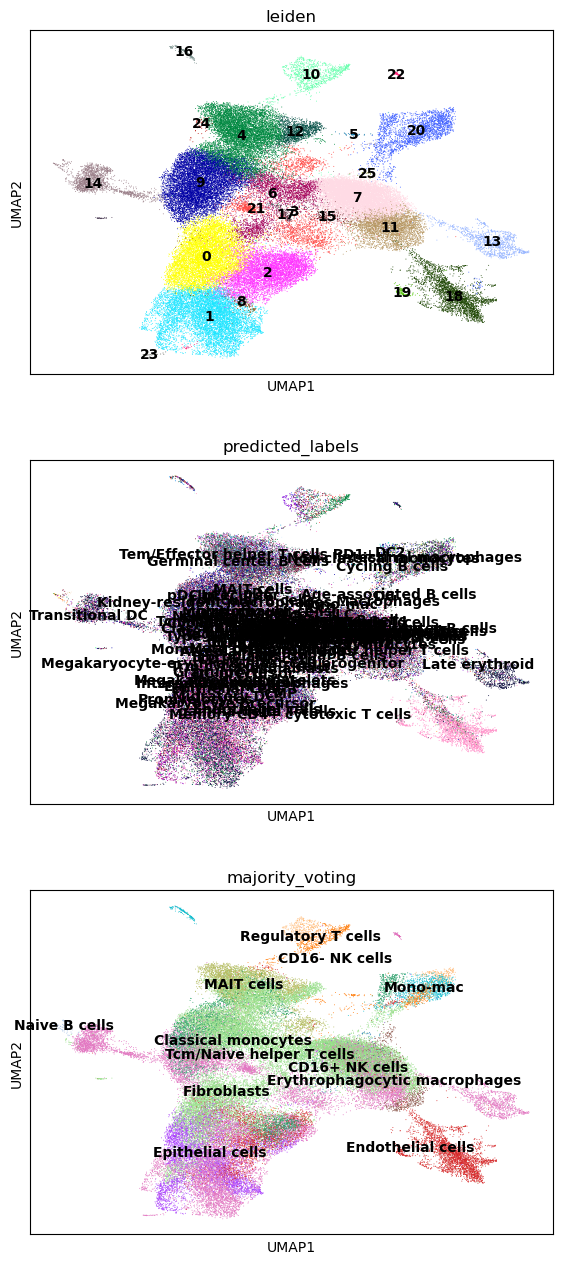

In [208]:
sc.pl.umap(filtered_combined_int, color=['leiden', 'predicted_labels', 'majority_voting'], legend_loc='on data', ncols=1)

# Cell Label Annotation - Manual

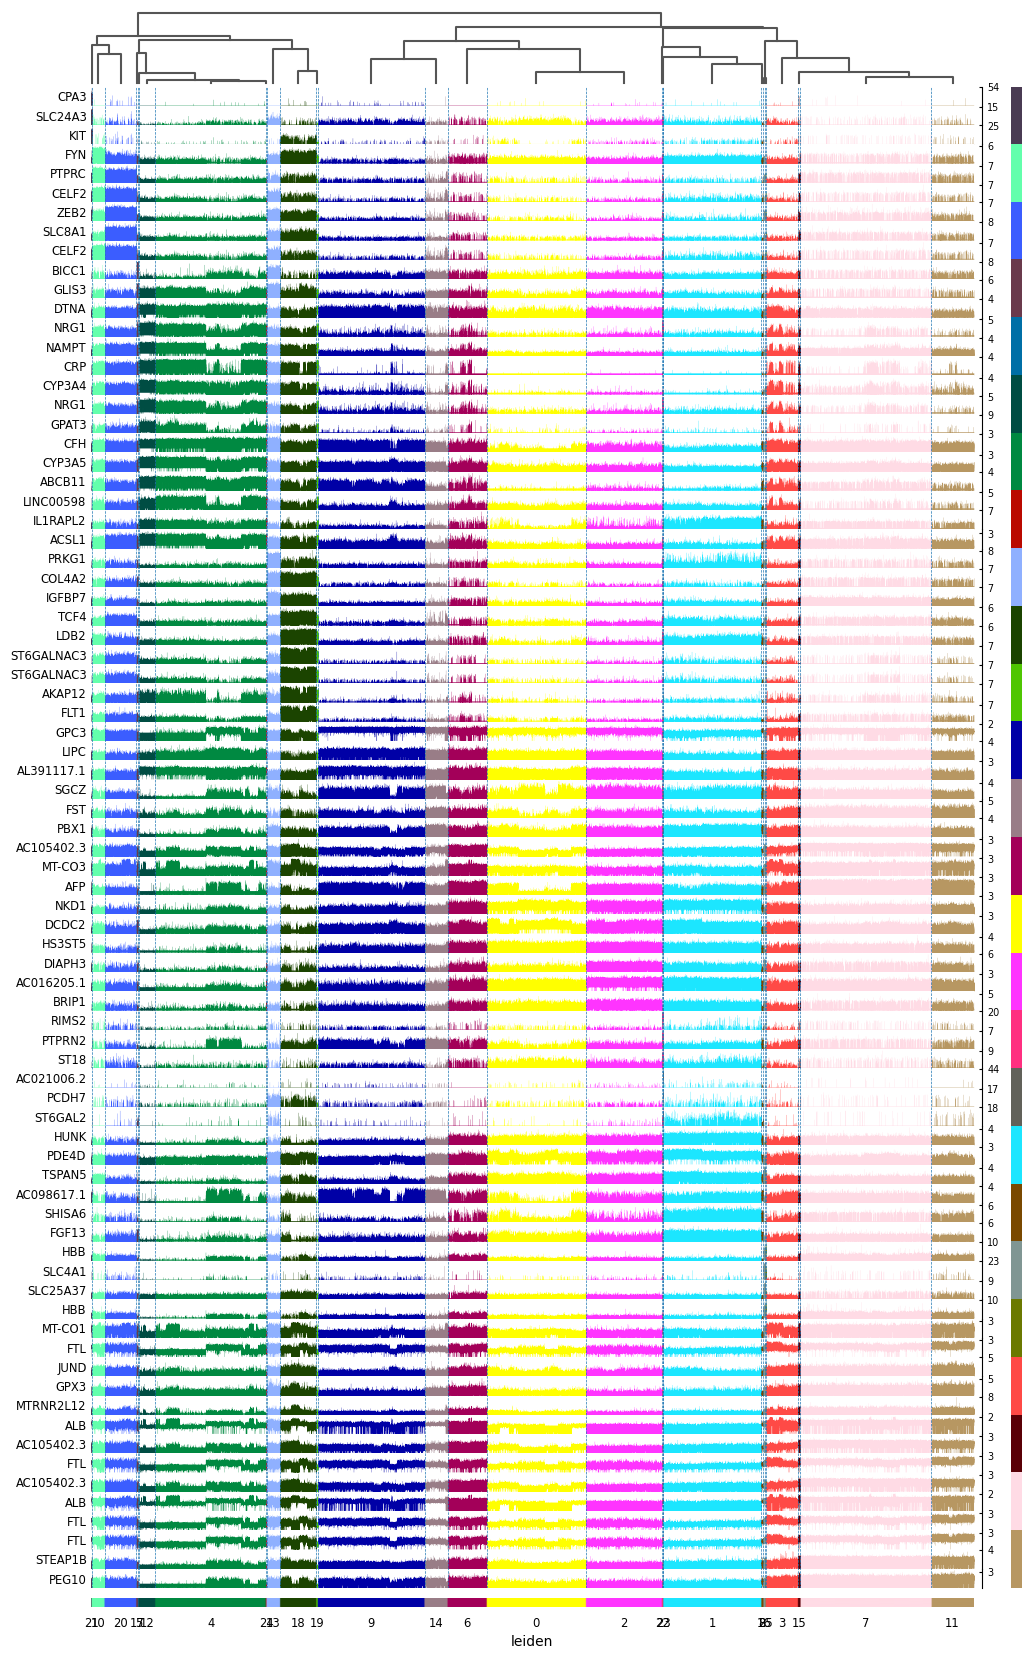

In [152]:
sc.pl.rank_genes_groups_tracksplot(filtered_combined_int, n_genes=3)

In [ ]:
cluster_counts = filtered_combined_int.obs['leiden'].value_counts()
print(cluster_counts)

In [179]:
top3_clusters = marker_table.iloc[[25,20,23]]
top3_clusters

gene
cluster                                       
9        GPC3, LIPC, AL391117.1, NR1H4, PTP4A1
4               CFH, CYP3A5, ABCB11, PCSK6, C3
7         AC105402.3, ALB, FTL, MT-CO3, MT-CO1

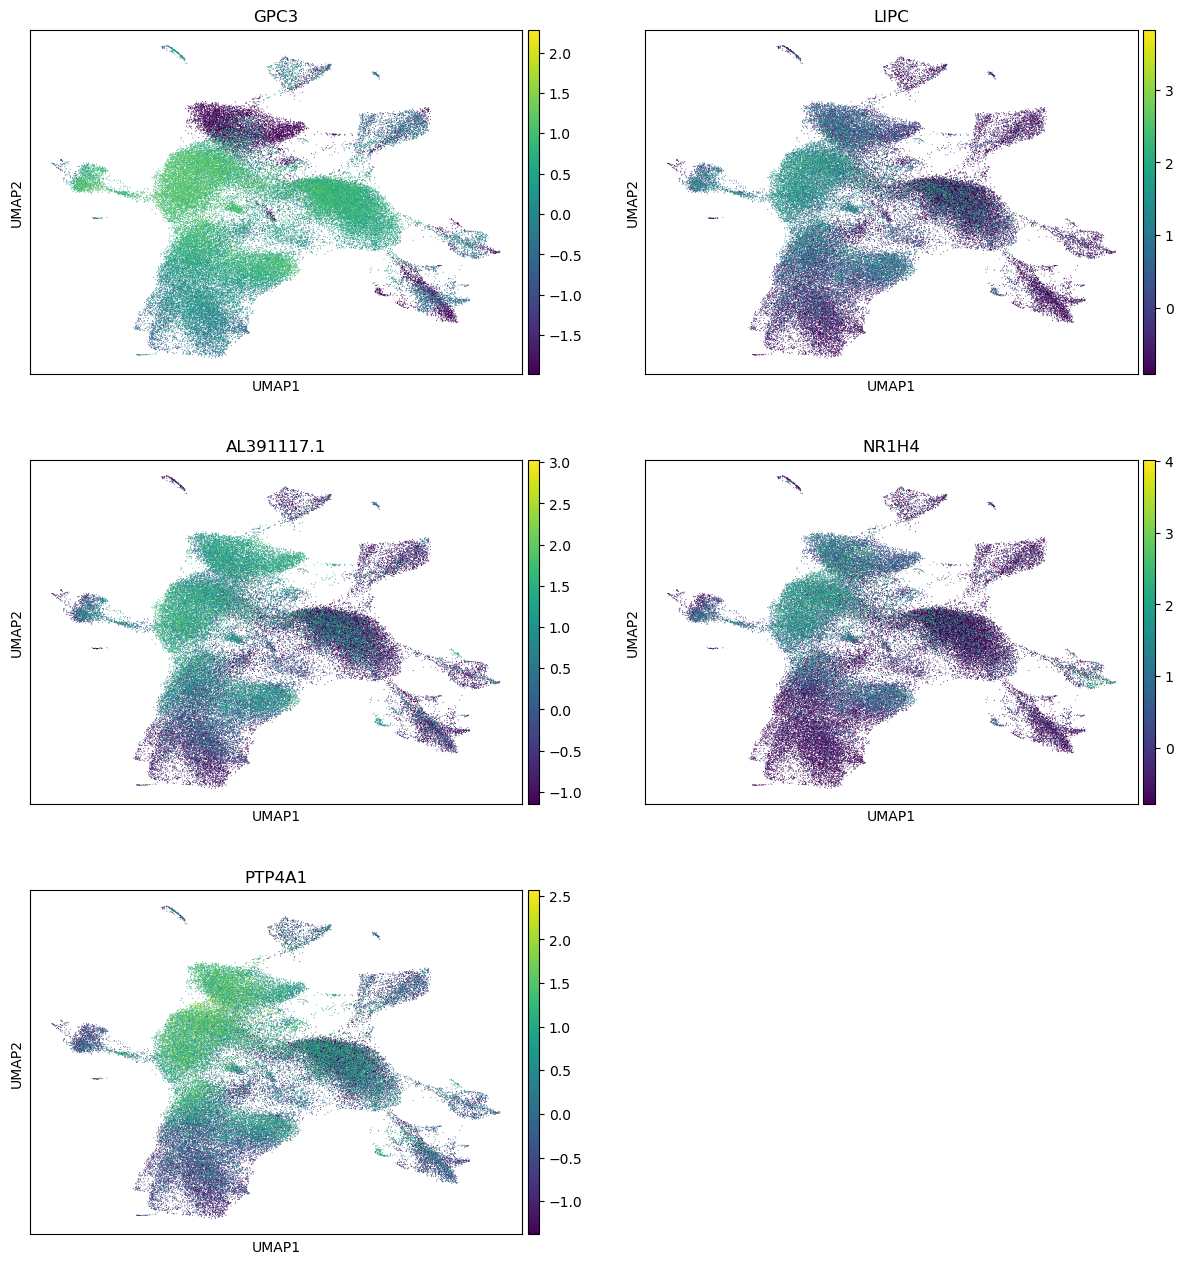

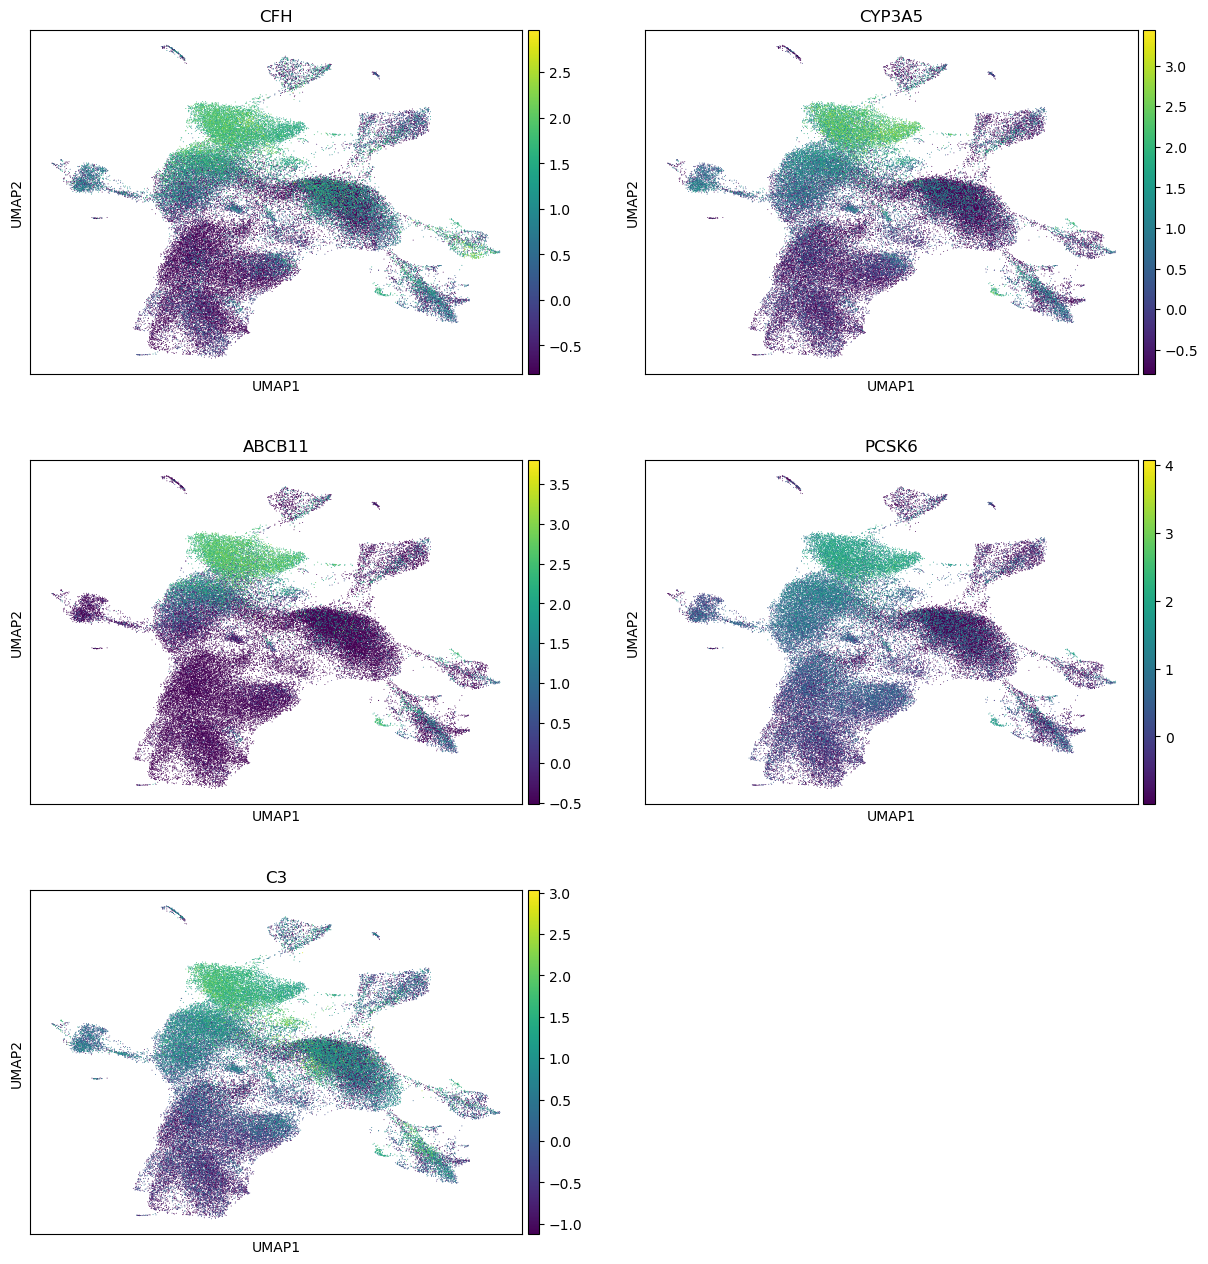

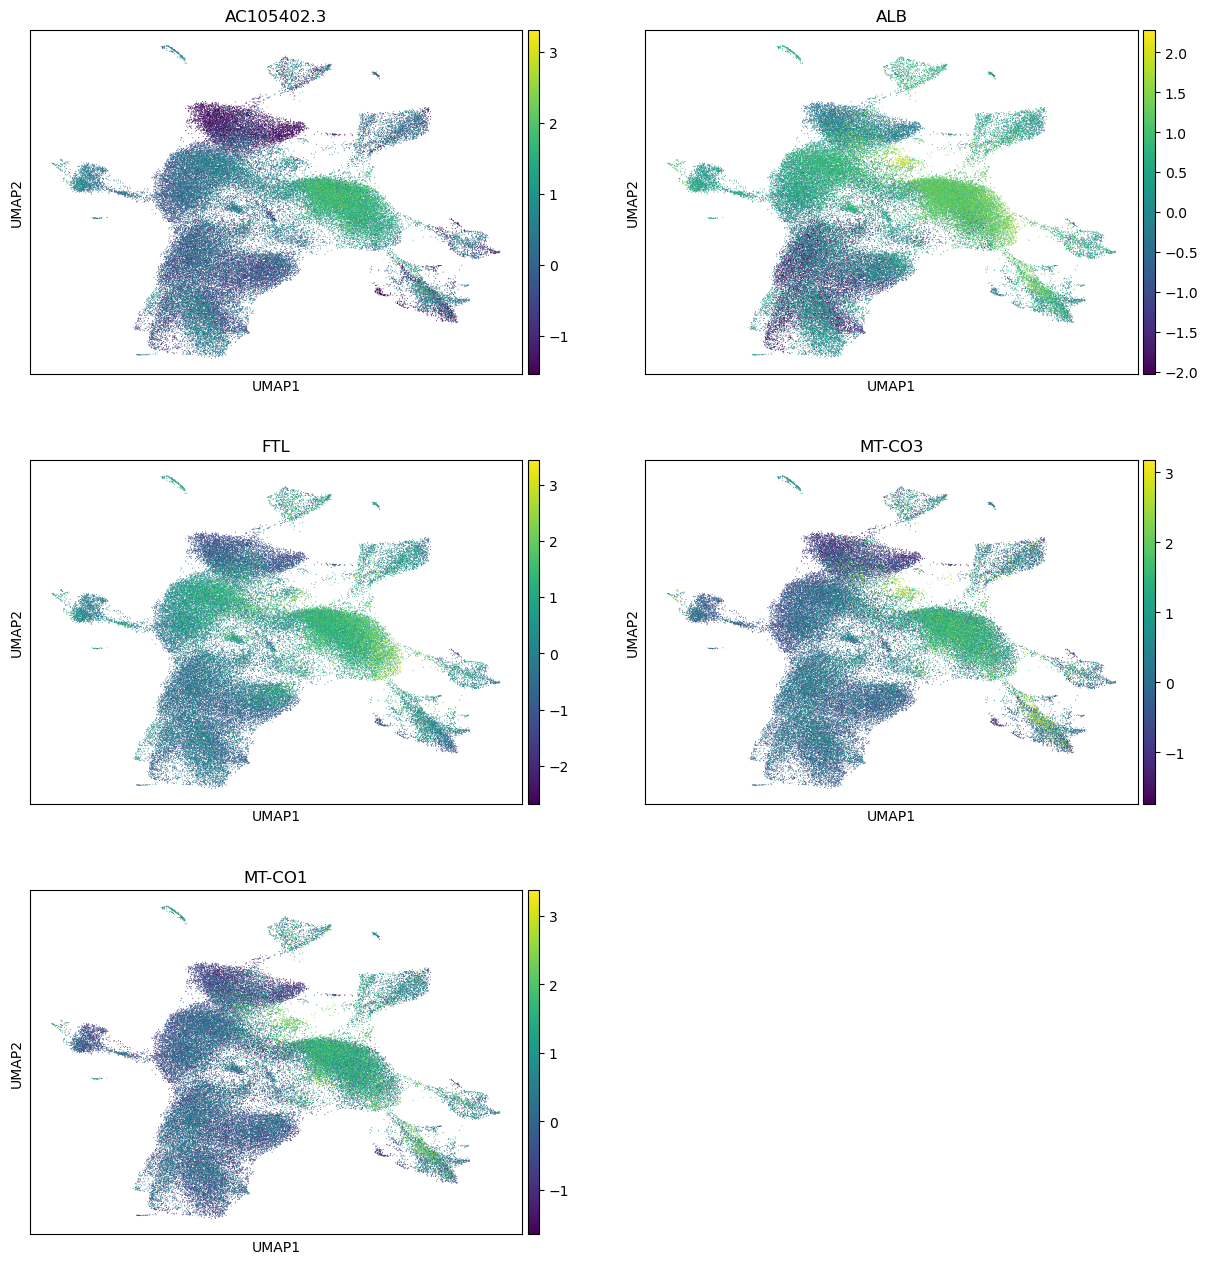

In [187]:
for index, row in top3_clusters.iterrows():
    gene_list = [g.strip() for g in row['gene'].split(',')]
    sc.pl.umap(filtered_combined_int, color=gene_list, ncols=2)

In [188]:
marker_table

gene
cluster                                             
0             NKD1, DCDC2, HS3ST5, FRAS1, SNAP25-AS1
1                   HUNK, PDE4D, TSPAN5, NRXN3, NKD1
10                 FYN, PTPRC, CELF2, PRKCH, ANKRD44
11              FTL, STEAP1B, PEG10, AC105402.3, ALB
12               CYP3A4, NRG1, GPAT3, CYP3A5, CYP2B6
13               PRKG1, COL4A2, IGFBP7, PDE3A, ZFPM2
14           SGCZ, FST, PBX1, AC007319.1, AC098617.1
15                  ALB, AC105402.3, FTL, FGB, PEG10
16              HBB, SLC4A1, SLC25A37, SPTA1, SPECC1
17                  BICC1, GLIS3, DTNA, STK39, CREB5
18               TCF4, LDB2, ST6GALNAC3, PTPRB, FLT1
19          ST6GALNAC3, AKAP12, FLT1, RAPGEF5, KALRN
2        DIAPH3, AC016205.1, BRIP1, RFC3, AC091057.6
20                ZEB2, SLC8A1, CELF2, DOCK2, PLXDC2
21                  CPA3, SLC24A3, KIT, HPGD, IL18R1
22                  RIMS2, PTPRN2, ST18, CADPS, DGKB
23         AC021006.2, PCDH7, ST6GAL2, CASC15, PDE4B
24          LINC00598, IL1RAPL2, ACSL1, STOM, ADRA1A
25                        HBB, MT-CO1, FTL, FGA, FGB
3                JUND, GPX3, MTRNR2L12, H3F3B, NORAD
4                     CFH, CYP3A5, ABCB11, PCSK6, C3
5                      NRG1, NAMPT, CRP, ABCB11, SDS
6                 AC105402.3, MT-CO3, AFP, FTL, GPC3
7               AC105402.3, ALB, FTL, MT-CO3, MT-CO1
8               AC098617.1, SHISA6, FGF13, NTM, CPS1
9              GPC3, LIPC, AL391117.1, NR1H4, PTP4A1

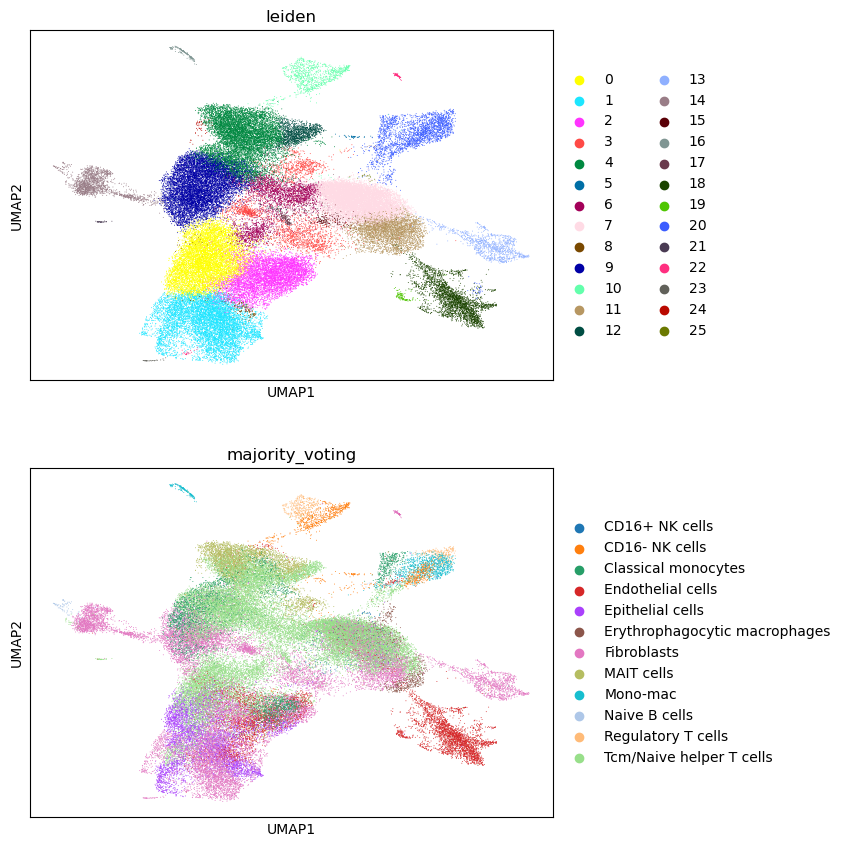

In [209]:
sc.pl.umap(filtered_combined_int, color=['leiden', 'majority_voting'], ncols=1)

In [237]:
six = sc.get.rank_genes_groups_df(filtered_combined_int, group=str(14))
six.head(10)

names     scores  logfoldchanges          pvals      pvals_adj
0        SGCZ  40.622456             NaN   0.000000e+00   0.000000e+00
1         FST  40.443695             NaN   0.000000e+00   0.000000e+00
2        PBX1  40.222740             NaN   0.000000e+00   0.000000e+00
3  AC007319.1  39.206032             NaN   0.000000e+00   0.000000e+00
4  AC098617.1  39.204391             NaN   0.000000e+00   0.000000e+00
5      KIF26B  37.025795             NaN  4.404656e-300  2.202328e-297
6      CXCL12  36.041435             NaN  1.878507e-284  8.050746e-282
7       PREX2  34.879482             NaN  1.521882e-266  5.707057e-264
8     ANKRD44  34.329506             NaN  2.848680e-258  9.495599e-256
9       PLCB1  32.364525             NaN  8.666844e-230  2.600053e-227

Manual Labeling

In [244]:
if 'manual_label' not in filtered_combined_int.obs:
    filtered_combined_int.obs['manual_label'] = None

filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '0'] = 'Epethelial/Mesenchymal'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '1'] = 'Epethelial/Mesenchymal'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '2'] = 'Epethelial/Mesenchymal'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '3'] = 'Tumor cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '4'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '5'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '6'] = 'Tumor cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '7'] = 'Tumor cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '8'] = 'Epethelial/Mesenchymal'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '9'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '10'] = 'T/NK cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '11'] = 'Tumor cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '12'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '13'] = 'Endothelial/Mesenchymal'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '14'] = 'Fibroblasts'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '15'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '16'] = 'Erythroid cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '17'] = 'Hepatic progenitor cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '18'] = 'Endothelial'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '19'] = 'Endothelial'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '20'] = 'Monocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '21'] = 'Mast cells'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '22'] = 'Neurons'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '23'] = 'Neurons'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '24'] = 'Hepatocytes'
filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '25'] = 'Erythroid cells'

/scratch/4604493.1.academic/ipykernel_644628/1304078193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '0'] = 'Epethelial/Mesenchymal'
/scratch/4604493.1.academic/ipykernel_644628/1304078193.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_int.obs['manual_label'][filtered_combined_int.obs['leiden'] == '1'] = 'Epethelial/Mesenchymal'
/scratch/4604493.1.academic/ipykernel_644628/1304078193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

... storing 'manual_label' as categorical


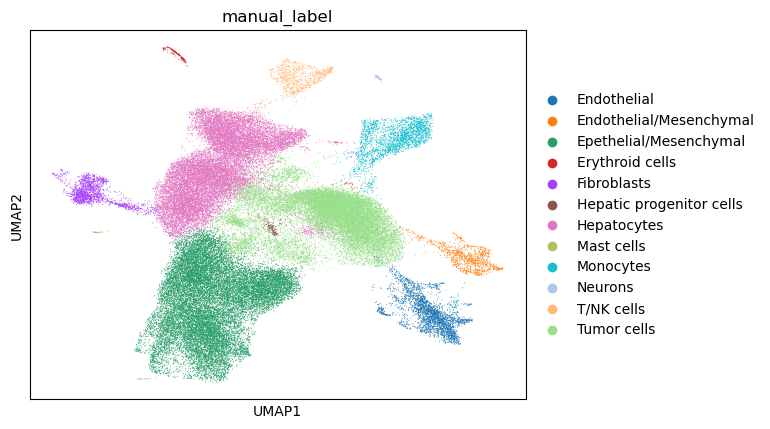

In [245]:
sc.pl.umap(filtered_combined_int, color='manual_label')

# Study Analysis 1 - RNA Velocity